In [1]:
!pip install neuralforecast pandas==2.2.1

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import torch

# 创建数据库引擎
database_url = "sqlite:////content/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
save_imputed_data = False
notebook_mode = 'train'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

model_name = 'Autoformer'
model_version = '1.0.0'
saved_table = 'sh_customs_daily_pred'

In [3]:
query = "select date as ds,global_entry,hkmo_entry,tw_entry from sh_customs_daily_imputed"
data = pd.read_sql_query(query, engine)
original_data = data.copy()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

for column in data.columns:
    if column not in ['ds']:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1)).reshape(
            -1)
        scalers[column] = scaler

In [5]:
# melting,转换为长格式
df_long = pd.melt(data, id_vars=['ds'], var_name='unique_id', value_name='y')
df_long['ds'] = pd.to_datetime(df_long.ds)

## 使用cross validation选择模型

使用RTX 4070Ti GPU 训练3小时

In [6]:
from neuralforecast.utils import augment_calendar_df

df_augmented, calendar_cols = augment_calendar_df(df=df_long, freq='D')
df_augmented.head()

,ds,unique_id,y,weekday,monthday,yearday
0,2011-01-01,global_entry,0.396160,0.333333,-0.500000,-0.500000
1,2011-01-02,global_entry,0.397200,0.500000,-0.466667,-0.497260
2,2011-01-03,global_entry,0.425135,-0.500000,-0.433333,-0.494521
3,2011-01-04,global_entry,0.448877,-0.333333,-0.400000,-0.491781
4,2011-01-05,global_entry,0.441945,-0.166667,-0.366667,-0.489041


In [7]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [60]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models.autoformer import Autoformer

horizon = 30 # a month
model = Autoformer(h=horizon,
                 input_size=5*horizon, # 3 month
                 hidden_size = 512,
                 conv_hidden_size = 256,
                 n_head=8,
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=1000,
                 val_check_steps=100,
                 windows_batch_size=256,
                 early_stop_patience_steps=3,
                 random_seed=42)

nf = NeuralForecast(
    models=[model],
    freq='D',
)
nf.fit(df=df_augmented, val_size=int(0.1 * df_augmented.shape[0]))


INFO:lightning_fabric.utilities.seed:Seed set to 42


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

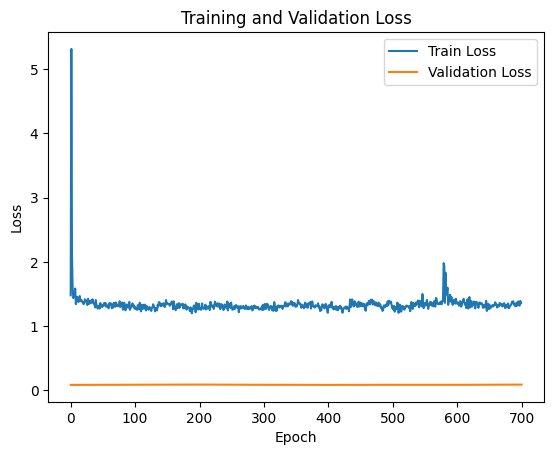

In [61]:
train = nf.models[0].train_trajectories
valid = nf.models[0].valid_trajectories

# Creating DataFrames for easy plotting
df_train_loss = pd.DataFrame(train, columns=['Epoch', 'Train Loss'])
df_valid_loss = pd.DataFrame(valid, columns=['Epoch', 'Validation Loss'])

# Plotting
plt.plot(df_train_loss['Epoch'], df_train_loss['Train Loss'], label='Train Loss')
plt.plot(df_valid_loss['Epoch'], df_valid_loss['Validation Loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
df_insample = nf.predict_insample(step_size=1)
df_insample

Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,cutoff,Autoformer,y
0,global_entry,2011-01-01,2010-12-31,-0.005178,0.396160
1,global_entry,2011-01-02,2010-12-31,-0.005178,0.397200
2,global_entry,2011-01-03,2010-12-31,-0.005178,0.425135
3,global_entry,2011-01-04,2010-12-31,-0.005178,0.448877
4,global_entry,2011-01-05,2010-12-31,-0.005178,0.441945
...,...,...,...,...,...
1266295,tw_entry,2024-01-27,2023-11-02,0.525293,0.469791
1266296,tw_entry,2024-01-28,2023-11-02,0.407097,0.390201
1266297,tw_entry,2024-01-29,2023-11-02,0.485123,0.363284
1266298,tw_entry,2024-01-30,2023-11-02,0.484936,0.309644


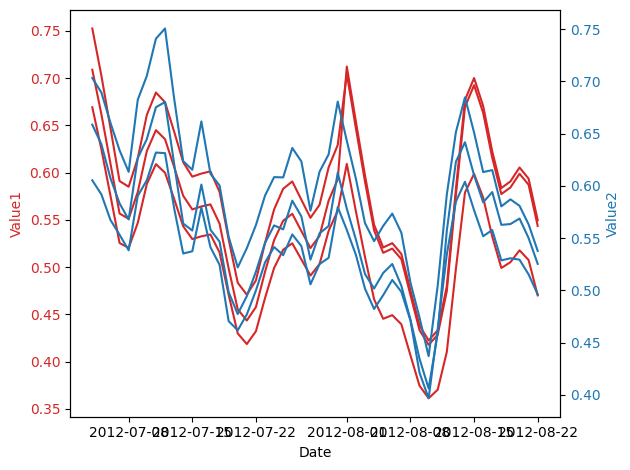

In [73]:
df_wide = df_insample.pivot_table(index='ds', columns='unique_id', values='y').reset_index().set_index('ds')
df_wide_autoformer = df_insample.pivot_table(index='ds', columns='unique_id', values='Autoformer').reset_index().set_index('ds')

fig, ax1 = plt.subplots()

# 绘制第一个 DataFrame
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color=color)
ax1.plot(df_wide.iloc[550:600,:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 实例化一个与ax1共享x轴的第二个坐标轴
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Value2', color=color)
ax2.plot(df_wide_autoformer.iloc[550:600,:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # 为了让图表看起来更整洁
plt.show()

In [45]:
import numpy as np
import pandas as pd

last_date = pd.to_datetime(data['ds']).max()

# 生成未来半年的日期序列，从最后一个日期的第二天开始
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# 创建一个新的DataFrame，包含未来的日期和原始DataFrame相同的列结构，其他列填充为NaN
# 注意：这里我们利用`.reindex`来扩展DataFrame，并填充NaN值
future_df = pd.DataFrame(index=future_dates,columns = data.columns)
# 将新生成的日期列命名为'ds'
future_df['ds'] = future_df.index
future_df_long = pd.melt(future_df, id_vars=['ds'], var_name='unique_id', value_name='y')
future_df_long['ds'] = pd.to_datetime(df_long.ds)
preds, futr_calendar_cols = augment_calendar_df(df=future_df_long, freq='D')
preds.drop(columns=['y'],inplace=True)
preds

,ds,unique_id,weekday,monthday,yearday
0,2011-01-01,global_entry,0.333333,-0.500000,-0.500000
1,2011-01-02,global_entry,0.500000,-0.466667,-0.497260
2,2011-01-03,global_entry,-0.500000,-0.433333,-0.494521
3,2011-01-04,global_entry,-0.333333,-0.400000,-0.491781
4,2011-01-05,global_entry,-0.166667,-0.366667,-0.489041
...,...,...,...,...,...
265,2011-09-23,tw_entry,0.166667,0.233333,0.226027
266,2011-09-24,tw_entry,0.333333,0.266667,0.228767
267,2011-09-25,tw_entry,0.500000,0.300000,0.231507
268,2011-09-26,tw_entry,-0.500000,0.333333,0.234247


In [46]:
nf.predict(df_long,futr_df=preds,step_size=1,random_seed=42)

ValueError: `futr_df` must have one row per id and ds in the forecasting horizon (90).